In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# =========================
# CONFIG
# =========================
ORIG_SAMPLES = 1024
RNN_SAMPLES  = 512      # downsample target
EPOCHS       = 20
BATCH_SIZE   = 256
MAX_PER_CLASS = None    # set to e.g. 30000 if you want cap

# =========================
# LOAD PREPROCESSED DATA
# =========================
X = np.load("X_rnn.npy")   # shape: (N, 1024, 2)
y = np.load("y.npy")

print("Loaded:", X.shape, y.shape)

NUM_CLASSES = len(np.unique(y))
print("Detected classes:", NUM_CLASSES)

# =========================
# OPTIONAL: LIMIT PER CLASS
# =========================
if MAX_PER_CLASS is not None:
    X_limited = []
    y_limited = []

    for c in range(NUM_CLASSES):
        idx = np.where(y == c)[0][:MAX_PER_CLASS]
        X_limited.append(X[idx])
        y_limited.append(y[idx])

    X = np.vstack(X_limited)
    y = np.hstack(y_limited)

    print("After class cap:", X.shape)

# =========================
# DOWNSAMPLE (1024 → 512)
# =========================
if RNN_SAMPLES < ORIG_SAMPLES:
    factor = ORIG_SAMPLES // RNN_SAMPLES
    X = X[:, ::factor, :]

assert X.shape[1] == RNN_SAMPLES

# =========================
# SHUFFLE
# =========================
X, y = shuffle(X, y, random_state=42)

# =========================
# SPLIT (70 / 15 / 15)
# =========================
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

# =========================
# NORMALIZE (IMPORTANT)
# =========================
mean = np.mean(X_train)
std  = np.std(X_train) + 1e-8

X_train = (X_train - mean) / std
X_val   = (X_val   - mean) / std
X_test  = (X_test  - mean) / std

# =========================
# ONE-HOT
# =========================
y_train = to_categorical(y_train, NUM_CLASSES)
y_val   = to_categorical(y_val, NUM_CLASSES)
y_test  = to_categorical(y_test, NUM_CLASSES)

# =========================
# RNN MODEL
# =========================
model = Sequential([
    Input(shape=(RNN_SAMPLES, 2)),
    GRU(64, return_sequences=False),
    Dense(64, activation="tanh"),
    Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# =========================
# TRAIN
# =========================
early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)

# =========================
# TEST
# =========================
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("\nRNN Test Accuracy:", test_acc)

Raw shapes: (254739, 1024, 2) (254739, 1024, 2) (254679, 1024, 2)
Per-class after cap: 30000 30000 30000
Train: (63000, 512, 2)
Val:   (13500, 512, 2)
Test:  (13500, 512, 2)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 64)             │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,235 (59.51 KB)

 Trainable params: 15,235 (59.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 96s 751ms/step - accuracy: 0.3381 - loss: 1.0990 - val_accuracy: 0.3471 - val_loss: 1.0973
Epoch 2/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 91s 731ms/step - accuracy: 0.3549 - loss: 1.0969 - val_accuracy: 0.3687 - val_loss: 1.0941
Epoch 3/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 108s 870ms/step - accuracy: 0.3843 - loss: 1.0850 - val_accuracy: 0.5914 - val_loss: 0.8867
Epoch 4/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 110s 881ms/step - accuracy: 0.6379 - loss: 0.7725 - val_accuracy: 0.6781 - val_loss: 0.6791
Epoch 5/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 102s 824ms/step - accuracy: 0.7041 - loss: 0.6344 - val_accuracy: 0.7171 - val_loss: 0.6129
Epoch 6/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 90s 725ms/step - accuracy: 0.7365 - loss: 0.5607 - val_accuracy: 0.6393 - val_loss: 0.7117
Epoch 7/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 102s 823ms/step - accuracy: 0.7472 - loss: 0.5228 - val_accuracy: 0.7560 - val_loss: 0.5048
Epoch 8/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 98s 790ms/step - accuracy: 0.7637 - los


 RNN (GRU) CLASSIFICATION REPORT

              precision    recall  f1-score   support

     Class 0     0.7043    0.4753    0.5676      4500
     Class 1     0.6630    0.8071    0.7280      4500
     Class 2     0.8891    0.9849    0.9345      4500

    accuracy                         0.7558     13500
   macro avg     0.7521    0.7558    0.7434     13500
weighted avg     0.7521    0.7558    0.7434     13500



<Figure size 500x500 with 0 Axes>

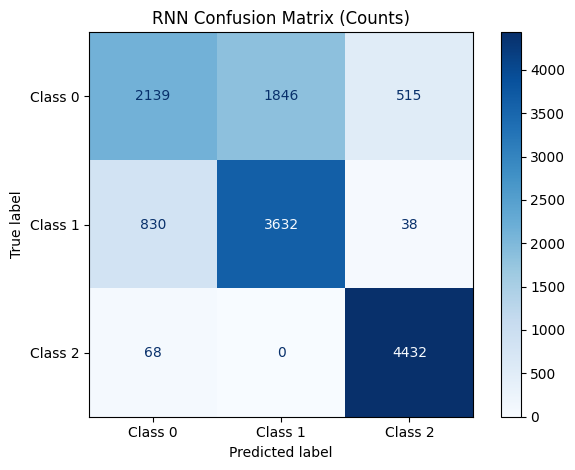

<Figure size 500x500 with 0 Axes>

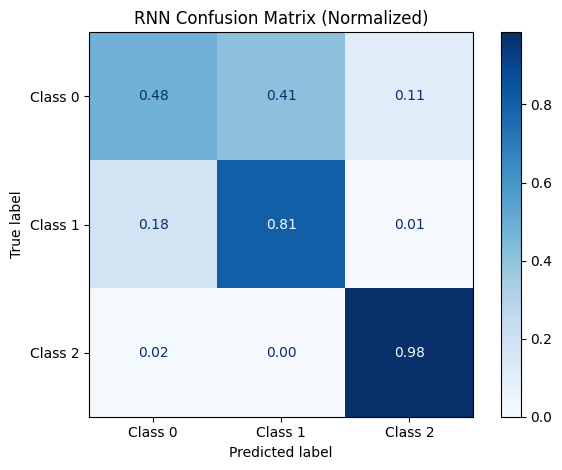


Per-class accuracy:
Class 0: 0.4753
Class 1: 0.8071
Class 2: 0.9849

Overall Test Accuracy: 0.7558


C:\Users\paray\AppData\Local\Temp\ipykernel_9748\3867904233.py:103: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\paray\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


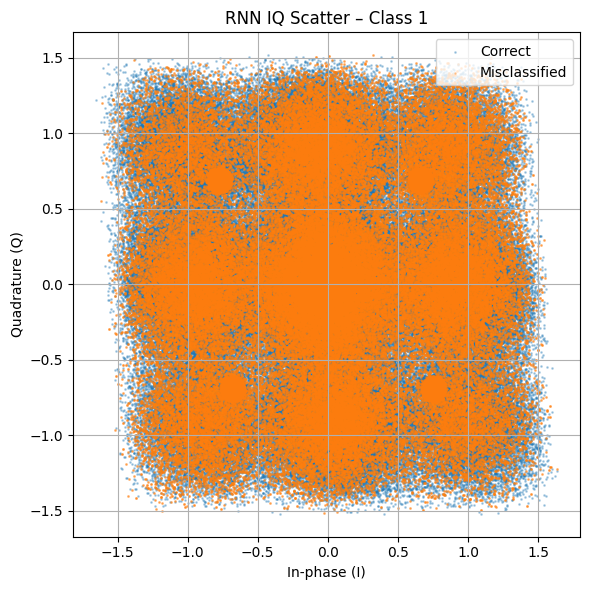

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# =========================
# PREDICTIONS
# =========================
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

NUM_CLASSES = y_test.shape[1]
class_names = [f"TX {i}" for i in range(NUM_CLASSES)]

# =========================
# CLASSIFICATION REPORT
# =========================
print("\n==============================")
print(" RNN CLASSIFICATION REPORT")
print("==============================\n")

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))

# =========================
# CONFUSION MATRIX 
# =========================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot(cmap="Blues", values_format="d")
plt.title("RNN Confusion Matrix (Counts)")
plt.grid(False)
plt.tight_layout()
plt.show()

# =========================
# CONFUSION MATRIX (NORMALIZED)
# =========================
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,6))
disp_norm = ConfusionMatrixDisplay(
    confusion_matrix=cm_norm,
    display_labels=class_names
)
disp_norm.plot(cmap="Blues", values_format=".2f")
plt.title("RNN Confusion Matrix (Normalized)")
plt.grid(False)
plt.tight_layout()
plt.show()

# =========================
# PER-CLASS ACCURACY
# =========================
print("\nPer-class accuracy:")
for c, name in enumerate(class_names):
    idx = y_true == c
    acc = np.mean(y_pred[idx] == c)
    print(f"{name}: {acc:.4f}")

print(f"\nOverall Test Accuracy: {np.mean(y_true == y_pred):.4f}")

# =========================
# CORRECT vs INCORRECT IQ SCATTER
# =========================
# RNN scatter
cls = 0

correct_idx = np.where((y_true == cls) & (y_pred == cls))[0][:200]
wrong_idx   = np.where((y_true == cls) & (y_pred != cls))[0][:200]

plt.figure(figsize=(6,6))

if len(correct_idx) > 0:
    I_correct = X_test[correct_idx][:, :, 0].flatten()
    Q_correct = X_test[correct_idx][:, :, 1].flatten()
    plt.scatter(I_correct, Q_correct, s=1, alpha=0.3, label="Correct")

if len(wrong_idx) > 0:
    I_wrong = X_test[wrong_idx][:, :, 0].flatten()
    Q_wrong = X_test[wrong_idx][:, :, 1].flatten()
    plt.scatter(I_wrong, Q_wrong, s=1, alpha=0.5, label="Misclassified")

plt.xlabel("In-phase (I)")
plt.ylabel("Quadrature (Q)")
plt.title(f"RNN IQ Scatter – TX {cls}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()